## Data processing

In [ ]:
import pandas as pd
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = '/Users/wangchenhui/UChicago/ML/Final_Project/dataset/'

In [ ]:
# load downloaded data
df_convos = pd.read_csv(path+'/conversations.csv')
df_speakers = pd.read_csv(path+'/speakers.csv')
df_utts = pd.read_csv(path+'/utterances.csv')
df_cases = pd.read_json(path_or_buf='https://zissou.infosci.cornell.edu/convokit/datasets/supreme-corpus/cases.jsonl', lines=True)
df_cases = df_cases[(df_cases['year'] >= 2011) & (df_cases['year'] <= 2018) & (df_cases['win_side'].isin([0,1]))]

In [ ]:
# combine text from all utterances in a conversation back into one string based on the conversation_id, coount how many utterances per conversation
utt_per_conv = df_utts.groupby('conversation_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
utt_per_conv['num_utterances'] = df_utts.groupby('conversation_id')['text'].count().reset_index()['text']

# add the combined text to the conversations dataframe, merge on conversation_id in utt_per_conv and id in df_convo
df_convos_utt = df_convos.merge(utt_per_conv, left_on='id', right_on='conversation_id', how='left')

In [ ]:
# combine text from all conversation in a cases into one string based on the meta.case_id
conv_per_case = df_convos_utt.groupby('meta.case_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
conv_per_case['num_conversations'] = df_convos_utt.groupby('meta.case_id')['text'].count().reset_index()['text']
conv_per_case['num_utterances'] = df_convos_utt.groupby('meta.case_id')['num_utterances'].sum().reset_index()['num_utterances']

# add the combined text case dataframe, merge on meta.case_id and id
df_cases_convo = df_cases.merge(conv_per_case, left_on='id', right_on='meta.case_id', how='left')

In [ ]:
df_cases_convo.dropna(subset=['text'], inplace=True)

In [ ]:
# transform to pd.to_datetime
df_cases_convo.decided_date = pd.to_datetime(df_cases_convo.decided_date)

In [ ]:
df_cases_convo.to_csv('df_cases_convo.csv', index=False)

## Clean Data

In [ ]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wangchenhui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wangchenhui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wangchenhui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Cleaning the text
def preprocess_text(text):
    text = text.lower() # Lowercase the text
    text = re.sub('[^a-z]+', ' ', text)  # Remove special characters and numbers
    text = re.sub(r'\b\w{1,3}\b', '', text) # Remove words with length less than 3
    words = nltk.word_tokenize(text) # Tokenize the text
    stop_words = set(stopwords.words('english')) # Remove stopwords
    words = [word for word in words if word not in stop_words]
    #lemmatizer = WordNetLemmatizer() # Lemmatize the words comment because slow
    #words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words) # Reconstruct the text

    return text

In [ ]:
df = df_cases_convo.copy()

In [ ]:
# preprocess text
df.loc[:, 'text_pre'] = df['text'].apply(preprocess_text)

In [ ]:
# preprocess develop time
df.loc[:, 'start_date'] = df['transcripts'].apply(lambda x : re.findall(r'[A-Z][a-z]+ \d{2}, \d{4}', x[0]['name'])[0])
df.start_date = pd.to_datetime(df.start_date)
df.loc[:, 'develop_time'] = df.loc[:, 'decided_date'] - df.loc[:, 'start_date'] 
# df['develop_time'] = df['develop_time'].apply(lambda x : x.days)

In [ ]:
# get party of the judges

def check_party_pc(x):
    rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
    dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']
    
    rep_ct = 0
    
    for judge in x:
        if judge in rep_judge:
            rep_ct += 1
    
    return rep_ct/len(x)

In [ ]:
df['votes_side'][1]['j__john_g_roberts_jr']

0.0

In [ ]:
# get rep_judge yes

def check_rep_j_y_pc(x):
    rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
    dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']
    
    rep_y_ct = 0
    
    for judge in x:
        if judge in rep_judge: 
            if x[judge] > 0:
                rep_y_ct += 1
    
    return rep_y_ct/len(x)

In [ ]:
# get dem_judge yes

def check_dem_j_y_pc(x):
    rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
    dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']
    
    dem_y_ct = 0
    
    for judge in x:
        if judge in dem_judge: 
            if x[judge] > 0:
                dem_y_ct += 1
    
    return dem_y_ct/len(x)

In [ ]:
def check_party(x):
    if x > 2009:
        return 0
    else:
        return 1

In [ ]:
# only numbers can apply to Random Forest Model
df_rf = pd.DataFrame()
df_rf.loc[:, 'text_len'] = df['text'].apply(lambda x : len(x))
df_rf.loc[:, 'text_pre_len'] = df['text_pre'].apply(lambda x : len(x))
df_rf.loc[:, 'num_utterances'] = df['num_utterances']
df_rf.loc[:, 'win_side'] = df['win_side']
df_rf.loc[:, 'develop_time'] = df['develop_time'].apply(lambda x : x.days)
df_rf.loc[:, 'rep_jpc'] = df['votes_side'].apply(check_party_pc)
df_rf.loc[:, 'rep_j_y_pc'] = df['votes_side'].apply(check_rep_j_y_pc)
df_rf.loc[:, 'dem_j_y_pc'] = df['votes_side'].apply(check_dem_j_y_pc)
df_rf.loc[:, 'party'] = df['year'].apply(check_party) # 1:  rep, 0: dem

df_rf

,text_len,text_pre_len,num_utterances,win_side,develop_time,rep_jpc,rep_j_y_pc,dem_j_y_pc,party
1,81913,44829,295.0,0.0,61,0.625000,0.375000,0.000000,0
2,66589,34303,239.0,0.0,96,0.555556,0.333333,0.000000,0
3,55436,29849,201.0,1.0,63,0.555556,0.555556,0.444444,0
4,55012,29892,191.0,0.0,92,0.555556,0.000000,0.333333,0
6,59768,31534,210.0,1.0,134,0.555556,0.555556,0.444444,0
...,...,...,...,...,...,...,...,...,...
595,65067,35907,167.0,1.0,62,0.555556,0.555556,0.444444,0
596,61137,32779,179.0,0.0,91,0.555556,0.333333,0.111111,0
597,58012,32112,220.0,0.0,224,0.555556,0.222222,0.111111,0
598,67120,34254,319.0,0.0,140,0.555556,0.444444,0.000000,0


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import itertools

In [ ]:
def get_accuracy(feature_lst, X, df):
    
    
    #set y dataset
    y = df['win_side']
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # create the model
    model = RandomForestClassifier()
    # train the model 
    model.fit(X_train, y_train)
    # Test the model
    predictions = model.predict(X_train)
    # Make the predictions
    y_pred = model.predict(X_test)
    
    dict1 = {'features': feature_lst,
             'features_num': len(feature_lst),
             'accuracy': accuracy_score(y_test, y_pred),
             'f1': f1_score(y_test, y_pred),
             'precision': precision_score(y_test, y_pred),
             'recall': recall_score(y_test, y_pred)}
    
    return dict1

In [ ]:
# Define the list
#'rep_jpc', 'dem_j_y_pc', 'rep_j_y_pc'
features_list = ['text_len', 'text_pre_len', 'num_utterances', 'develop_time', 
                 'rep_jpc', 'party']

# Get all possible combinations of the list
combinations = []
for i in range(1, len(features_list) + 1):
    combinations += list(itertools.combinations(features_list, i))

for i in range(len(combinations)):
    combinations[i] = list(combinations[i] )
combinations

[['text_len'],
 ['text_pre_len'],
 ['num_utterances'],
 ['develop_time'],
 ['rep_jpc'],
 ['party'],
 ['text_len', 'text_pre_len'],
 ['text_len', 'num_utterances'],
 ['text_len', 'develop_time'],
 ['text_len', 'rep_jpc'],
 ['text_len', 'party'],
 ['text_pre_len', 'num_utterances'],
 ['text_pre_len', 'develop_time'],
 ['text_pre_len', 'rep_jpc'],
 ['text_pre_len', 'party'],
 ['num_utterances', 'develop_time'],
 ['num_utterances', 'rep_jpc'],
 ['num_utterances', 'party'],
 ['develop_time', 'rep_jpc'],
 ['develop_time', 'party'],
 ['rep_jpc', 'party'],
 ['text_len', 'text_pre_len', 'num_utterances'],
 ['text_len', 'text_pre_len', 'develop_time'],
 ['text_len', 'text_pre_len', 'rep_jpc'],
 ['text_len', 'text_pre_len', 'party'],
 ['text_len', 'num_utterances', 'develop_time'],
 ['text_len', 'num_utterances', 'rep_jpc'],
 ['text_len', 'num_utterances', 'party'],
 ['text_len', 'develop_time', 'rep_jpc'],
 ['text_len', 'develop_time', 'party'],
 ['text_len', 'rep_jpc', 'party'],
 ['text_pre_len

In [ ]:
results = []

# get accu from each diff features combinations
for feature_lst in combinations:
    results.append(get_accuracy(feature_lst, df_rf.loc[:,feature_lst], df_rf))

# get accu from ngram, bigram
results.append(get_accuracy(['ngram_text'], CountVectorizer().fit_transform(df['text_pre']), df))
results.append(get_accuracy(['bigram_text'], TfidfVectorizer().fit_transform(df['text_pre']), df))

In [ ]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results)
results_df

,features,features_num,accuracy,f1,precision,recall
0,[text_len],1,0.533333,0.642336,0.594595,0.698413
1,[text_pre_len],1,0.552381,0.635659,0.719298,0.569444
2,[num_utterances],1,0.495238,0.624113,0.578947,0.676923
3,[develop_time],1,0.485714,0.619718,0.536585,0.733333
4,[rep_jpc],1,0.647619,0.786127,0.653846,0.985507
...,...,...,...,...,...,...
60,"[text_len, num_utterances, develop_time, rep_j...",5,0.561905,0.689189,0.593023,0.822581
61,"[text_pre_len, num_utterances, develop_time, r...",5,0.542857,0.671233,0.604938,0.753846
62,"[text_len, text_pre_len, num_utterances, devel...",6,0.638095,0.753247,0.690476,0.828571
63,[ngram_text],1,0.628571,0.769231,0.631068,0.984848


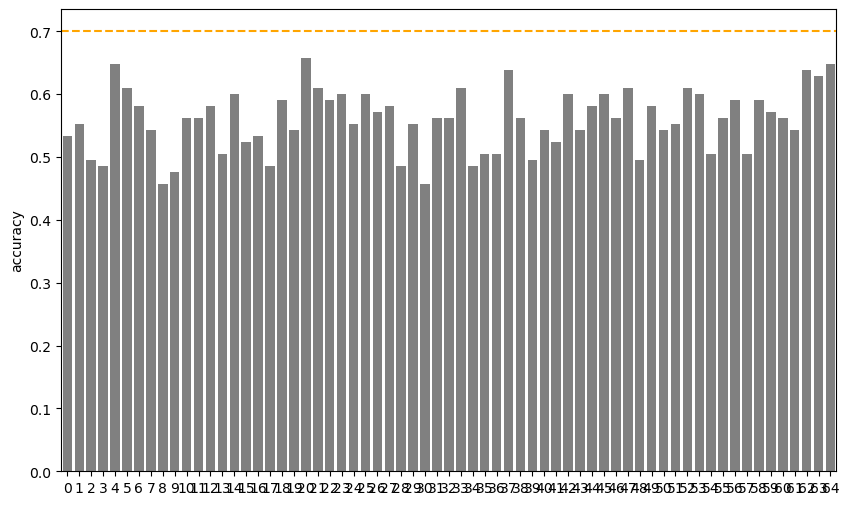

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x = results_df.index, y='accuracy', color='grey', data=results_df)
plt.axhline(y=0.7, color='orange', linestyle='--')

In [ ]:
results_df.loc[(results_df.loc[:, 'accuracy'] > 0.6), :]

,features,features_num,accuracy,f1,precision,recall
4,[rep_jpc],1,0.647619,0.786127,0.653846,0.985507
5,[party],1,0.609524,0.757396,0.609524,1.000000
20,"[rep_jpc, party]",2,0.657143,0.793103,0.657143,1.000000
21,"[text_len, text_pre_len, num_utterances]",3,0.609524,0.709220,0.714286,0.704225
33,"[text_pre_len, num_utterances, party]",3,0.609524,0.717241,0.712329,0.722222
37,"[num_utterances, develop_time, rep_jpc]",3,0.638095,0.756410,0.710843,0.808219
47,"[text_len, num_utterances, develop_time, rep_jpc]",4,0.609524,0.738854,0.637363,0.878788
52,"[text_pre_len, num_utterances, develop_time, p...",4,0.609524,0.717241,0.597701,0.896552
62,"[text_len, text_pre_len, num_utterances, devel...",6,0.638095,0.753247,0.690476,0.828571
63,[ngram_text],1,0.628571,0.769231,0.631068,0.984848
